In [3]:
import os, math, time, glob
import numpy as np, pandas as pd, geopandas as gpd
from shapely.geometry import Point, Polygon
from shapely.ops import unary_union
import osmnx as ox
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GroupKFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

import folium, json
import joblib

# Use the exact CSV path you gave
CSV_PATH = r"C:\Users\Croma\OneDrive\Desktop\GNR627 - Geospacial predictive modeling\dft-road-casualty-statistics-collision-last-5-years.csv"

# Working folder for intermediate outputs (change if you want)
WORK_DIR = os.path.join(os.path.expanduser("~"), "stats19_run_outputs")
os.makedirs(WORK_DIR, exist_ok=True)
print("WORK_DIR:", WORK_DIR)
print("CSV_PATH:", CSV_PATH)


WORK_DIR: C:\Users\Croma\stats19_run_outputs
CSV_PATH: C:\Users\Croma\OneDrive\Desktop\GNR627 - Geospacial predictive modeling\dft-road-casualty-statistics-collision-last-5-years.csv


In [4]:
CSV_PATH = r"C:\Users\Croma\OneDrive\Desktop\GNR627 - Geospacial predictive modeling\dft-road-casualty-statistics-collision-last-5-years.csv"

# Load in chunks and concatenate only needed columns
chunks = []
usecols = None  # or pick just needed ones later

for chunk in pd.read_csv(CSV_PATH, engine='python', chunksize=200000):
    chunks.append(chunk)

df = pd.concat(chunks, ignore_index=True)
print("Rows loaded:", len(df))
print(df.head())


Rows loaded: 503475
  collision_index  collision_year collision_ref_no  location_easting_osgr  \
0   2020170H10890            2020        170H10890               446191.0   
1   2021170H10801            2021        170H10801               449617.0   
2   2021170M30061            2021        170M30061               454030.0   
3   2022170M10952            2022        170M10952               449180.0   
4   202417M114824            2024        17M114824               451027.0   

   location_northing_osgr  longitude   latitude  police_force  \
0                534540.0  -1.284731  54.703781            17   
1                528977.0  -1.232514  54.653469            17   
2                513371.0  -1.166988  54.512785            17   
3                520909.0  -1.240623  54.581003            17   
4                515965.0  -1.212910  54.536390            17   

   collision_severity  number_of_vehicles  ...  carriageway_hazards_historic  \
0                   3                   2  ...

In [13]:
# Diagnostic: inspect uploaded CSV & verify coordinate columns
import pandas as pd
import numpy as np
import geopandas as gpd
from pyproj import Transformer
from shapely.geometry import Point

CSV_PATH = r"C:\Users\Croma\OneDrive\Desktop\GNR627 - Geospacial predictive modeling\dft-road-casualty-statistics-collision-last-5-years.csv"

print("Reading header (nrows=5) to inspect columns...")
head = pd.read_csv(CSV_PATH, nrows=5, engine='python')
print(head)
print("\nCOLUMNS:")
print(head.columns.tolist())
print("\nFile size (rows) preview:")
try:
    # try quick row count estimate (fast)
    nrows = sum(1 for _ in open(CSV_PATH)) - 1
    print("Approx rows (including header):", nrows + 1)
except Exception as e:
    print("Could not count rows quickly:", e)

# Now try loading only coordinate-related columns if present
possible_lon = [c for c in head.columns if 'lon' in c.lower() or 'long' in c.lower()]
possible_lat = [c for c in head.columns if 'lat' in c.lower()]
possible_e = [c for c in head.columns if 'east' in c.lower()]
possible_n = [c for c in head.columns if 'north' in c.lower()]

print("\nDetected candidate columns:")
print(" longitude-like:", possible_lon)
print(" latitude-like: ", possible_lat)
print(" easting-like:  ", possible_e)
print(" northing-like: ", possible_n)

# Load only the detected coordinate columns (if any) plus a few helpers
cols_to_try = list(dict.fromkeys(possible_lon + possible_lat + possible_e + possible_n + ['collision_index','collision_year'] ))
print("\nAttempting to load columns:", cols_to_try)

dfcoords = pd.read_csv(CSV_PATH, usecols=[c for c in cols_to_try if c in head.columns], engine='python', low_memory=True)
print("Loaded coordinate subset; sample:")
print(dfcoords.head())

# Try to create lon/lat columns in a robust way
dfcoords = dfcoords.copy()
if possible_lon and possible_lat:
    lon_col = possible_lon[0]
    lat_col = possible_lat[0]
    dfcoords['longitude'] = pd.to_numeric(dfcoords[lon_col], errors='coerce')
    dfcoords['latitude'] = pd.to_numeric(dfcoords[lat_col], errors='coerce')
    print(f"\nUsing decimal lon/lat from columns: {lon_col}, {lat_col}")
elif possible_e and possible_n:
    e_col = possible_e[0]
    n_col = possible_n[0]
    print(f"\nConverting Easting/Northing columns: {e_col}, {n_col} -> lon/lat using EPSG:27700 -> EPSG:4326")
    transformer = Transformer.from_crs("epsg:27700", "epsg:4326", always_xy=True)
    xs = pd.to_numeric(dfcoords[e_col], errors='coerce').values
    ys = pd.to_numeric(dfcoords[n_col], errors='coerce').values
    valid = (~np.isnan(xs)) & (~np.isnan(ys))
    lon = np.full(len(xs), np.nan)
    lat = np.full(len(xs), np.nan)
    if valid.any():
        lons, lats = transformer.transform(xs[valid], ys[valid])
        lon[valid] = lons
        lat[valid] = lats
    dfcoords['longitude'] = lon
    dfcoords['latitude'] = lat
else:
    print("\nNo obvious coordinate columns found in header sample. We'll need to inspect full column names above.")

# Count valid points
valid_pts = dfcoords[['longitude','latitude']].dropna()
print("\nValid coords in sample subset:", len(valid_pts))
print(valid_pts.head())

# Try creating minimal GeoDataFrame with full file but reading in chunks to count valid rows:
valid_count = 0
first_valid_rows = []
chunksize = 200000
for chunk in pd.read_csv(CSV_PATH, chunksize=chunksize, engine='python'):
    # coerce possible lon/lat or easting/northing to numeric if present
    if possible_lon and possible_lat:
        chunk['longitude'] = pd.to_numeric(chunk[possible_lon[0]], errors='coerce')
        chunk['latitude']  = pd.to_numeric(chunk[possible_lat[0]], errors='coerce')
    elif possible_e and possible_n:
        xs = pd.to_numeric(chunk[possible_e[0]], errors='coerce').values
        ys = pd.to_numeric(chunk[possible_n[0]], errors='coerce').values
        valid = (~np.isnan(xs)) & (~np.isnan(ys))
        lon = np.full(len(xs), np.nan); lat = np.full(len(xs), np.nan)
        if valid.any():
            tr = Transformer.from_crs("epsg:27700", "epsg:4326", always_xy=True)
            lons, lats = tr.transform(xs[valid], ys[valid])
            lon[valid] = lons; lat[valid] = lats
        chunk['longitude'] = lon; chunk['latitude'] = lat
    else:
        # nothing to extract
        break

    chunk_valid = chunk[['longitude','latitude']].dropna()
    valid_count += len(chunk_valid)
    if len(first_valid_rows) < 5:
        first_valid_rows.extend(chunk_valid.head(5).values.tolist())

    # quick early-stop if we've counted many
    if valid_count > 0 and valid_count >= 1000:
        break

print(f"\nApprox valid coordinates found (early stop): {valid_count}")
print("Sample valid coordinates (first rows):", first_valid_rows[:5])


Reading header (nrows=5) to inspect columns...
  collision_index  collision_year collision_ref_no  location_easting_osgr  \
0   2020170H10890            2020        170H10890                 446191   
1   2021170H10801            2021        170H10801                 449617   
2   2021170M30061            2021        170M30061                 454030   
3   2022170M10952            2022        170M10952                 449180   
4   202417M114824            2024        17M114824                 451027   

   location_northing_osgr  longitude   latitude  police_force  \
0                  534540  -1.284731  54.703781            17   
1                  528977  -1.232514  54.653469            17   
2                  513371  -1.166988  54.512785            17   
3                  520909  -1.240623  54.581003            17   
4                  515965  -1.212910  54.536390            17   

   collision_severity  number_of_vehicles  ...  carriageway_hazards_historic  \
0                  

In [14]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point, Polygon
import math

# Re-load the full CSV (we know now it's safe)
CSV_PATH = r"C:\Users\Croma\OneDrive\Desktop\GNR627 - Geospacial predictive modeling\dft-road-casualty-statistics-collision-last-5-years.csv"

df = pd.read_csv(CSV_PATH, engine="python", low_memory=True)

# Drop missing lon/lat
df = df.dropna(subset=["longitude", "latitude"]).copy()
df["longitude"] = pd.to_numeric(df["longitude"], errors="coerce")
df["latitude"] = pd.to_numeric(df["latitude"], errors="coerce")
df = df.dropna(subset=["longitude", "latitude"])

print("Valid accident rows:", len(df))

# Convert to GeoDataFrame (WGS84 -> 3857 metric)
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df.longitude, df.latitude),
    crs="EPSG:4326"
).to_crs(3857)

# Build bounding polygon (convex hull)
hull = gdf.unary_union.convex_hull
hull_buffered = hull.buffer(2000)  # +2km padding for safety

print("Hull bounds:", hull_buffered.bounds)

# Automatic grid sizing
target_cells = 20000   # aim for ≤ 20k grid cells
min_cell = 200         # smallest size
max_cell = 5000        # upper bound

minx, miny, maxx, maxy = hull_buffered.bounds

for cell_size in [250, 500, 1000, 2000, 3000, 4000]:
    nx = int(math.ceil((maxx - minx) / cell_size))
    ny = int(math.ceil((maxy - miny) / cell_size))
    n_cells = nx * ny
    print(f"Trying cell={cell_size} → {n_cells} cells")
    if n_cells <= target_cells:
        final_cell = cell_size
        break
else:
    final_cell = 5000  # fallback

print("FINAL CELL SIZE:", final_cell)

# Build grid
polygons = []
ids = []
gid = 0

for x in np.arange(minx, maxx, final_cell):
    for y in np.arange(miny, maxy, final_cell):
        poly = Polygon([(x,y),(x+final_cell,y),(x+final_cell,y+final_cell),(x,y+final_cell)])
        polygons.append(poly)
        ids.append(gid)
        gid += 1

grid = gpd.GeoDataFrame({"grid_id": ids, "geometry": polygons}, crs=3857)

# clip grid to accident area
grid = gpd.overlay(grid, gpd.GeoDataFrame(geometry=[hull_buffered], crs=3857), how="intersection")
grid = grid.reset_index(drop=True)

print("Final grid cells:", len(grid))

grid.head()


Valid accident rows: 503410


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\533144728.py:28: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  hull = gdf.unary_union.convex_hull


Hull bounds: (-836603.8905599616, 6429086.586797352, 197903.2461113733, 8523215.749672849)
Trying cell=250 → 34672403 cells
Trying cell=500 → 8671230 cells
Trying cell=1000 → 2168325 cells
Trying cell=2000 → 542864 cells
Trying cell=3000 → 241155 cells
Trying cell=4000 → 135716 cells
FINAL CELL SIZE: 5000
Final grid cells: 62068


,grid_id,geometry
0,254,"POLYGON ((-831603.891 7704086.587, -831603.891..."
1,255,"POLYGON ((-831603.891 7709086.587, -831603.891..."
2,256,"POLYGON ((-831603.891 7714086.587, -831603.891..."
3,257,"POLYGON ((-831603.891 7719086.587, -831603.891..."
4,258,"POLYGON ((-831603.891 7724086.587, -831603.891..."


In [15]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point, Polygon
import math

# Re-load the full CSV (we know now it's safe)
CSV_PATH = r"C:\Users\Croma\OneDrive\Desktop\GNR627 - Geospacial predictive modeling\dft-road-casualty-statistics-collision-last-5-years.csv"

df = pd.read_csv(CSV_PATH, engine="python", low_memory=True)

# Drop missing lon/lat
df = df.dropna(subset=["longitude", "latitude"]).copy()
df["longitude"] = pd.to_numeric(df["longitude"], errors="coerce")
df["latitude"] = pd.to_numeric(df["latitude"], errors="coerce")
df = df.dropna(subset=["longitude", "latitude"])

print("Valid accident rows:", len(df))

# Convert to GeoDataFrame (WGS84 -> 3857 metric)
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df.longitude, df.latitude),
    crs="EPSG:4326"
).to_crs(3857)

# Build bounding polygon (convex hull)
hull = gdf.unary_union.convex_hull
hull_buffered = hull.buffer(2000)  # +2km padding for safety

print("Hull bounds:", hull_buffered.bounds)

# Automatic grid sizing
target_cells = 20000   # aim for ≤ 20k grid cells
min_cell = 200         # smallest size
max_cell = 5000        # upper bound

minx, miny, maxx, maxy = hull_buffered.bounds

for cell_size in [250, 500, 1000, 2000, 3000, 4000]:
    nx = int(math.ceil((maxx - minx) / cell_size))
    ny = int(math.ceil((maxy - miny) / cell_size))
    n_cells = nx * ny
    print(f"Trying cell={cell_size} → {n_cells} cells")
    if n_cells <= target_cells:
        final_cell = cell_size
        break
else:
    final_cell = 5000  # fallback

print("FINAL CELL SIZE:", final_cell)

# Build grid
polygons = []
ids = []
gid = 0

for x in np.arange(minx, maxx, final_cell):
    for y in np.arange(miny, maxy, final_cell):
        poly = Polygon([(x,y),(x+final_cell,y),(x+final_cell,y+final_cell),(x,y+final_cell)])
        polygons.append(poly)
        ids.append(gid)
        gid += 1

grid = gpd.GeoDataFrame({"grid_id": ids, "geometry": polygons}, crs=3857)

# clip grid to accident area
grid = gpd.overlay(grid, gpd.GeoDataFrame(geometry=[hull_buffered], crs=3857), how="intersection")
grid = grid.reset_index(drop=True)

print("Final grid cells:", len(grid))

grid.head()


Valid accident rows: 503410


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\533144728.py:28: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  hull = gdf.unary_union.convex_hull


Hull bounds: (-836603.8905599616, 6429086.586797352, 197903.2461113733, 8523215.749672849)
Trying cell=250 → 34672403 cells
Trying cell=500 → 8671230 cells
Trying cell=1000 → 2168325 cells
Trying cell=2000 → 542864 cells
Trying cell=3000 → 241155 cells
Trying cell=4000 → 135716 cells
FINAL CELL SIZE: 5000
Final grid cells: 62068


,grid_id,geometry
0,254,"POLYGON ((-831603.891 7704086.587, -831603.891..."
1,255,"POLYGON ((-831603.891 7709086.587, -831603.891..."
2,256,"POLYGON ((-831603.891 7714086.587, -831603.891..."
3,257,"POLYGON ((-831603.891 7719086.587, -831603.891..."
4,258,"POLYGON ((-831603.891 7724086.587, -831603.891..."


Total accidents (sum): 503410
Non-zero cells: 16991
Grid cells: 62068
count    62068.000000
mean         8.110621
std         56.925933
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max       3092.000000
Name: acc_count, dtype: float64


C:\Users\Croma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\mapclassify\classifiers.py:1767: UserWarning: Not enough unique values in array to form 6 classes. Setting k to 3.
  self.bins = quantile(y, k=k)


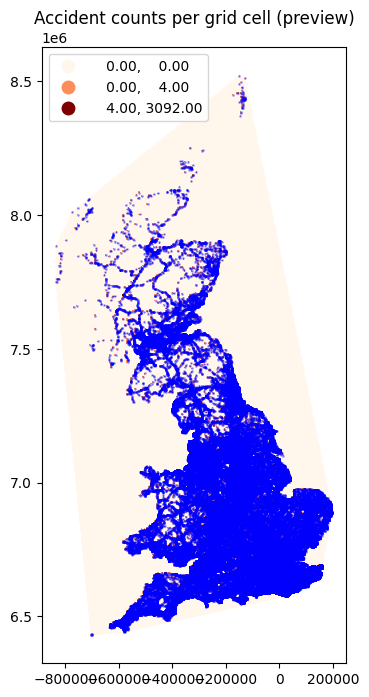

Saved grid_with_counts.geojson to: C:\Users\Croma\stats19_run_outputs\grid_with_counts.geojson


In [16]:
# ASSIGN ACCIDENTS TO GRID AND QUICK SUMMARY
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Point

# If you re-run from a fresh kernel, set CSV_PATH and WORK_DIR again:
CSV_PATH = r"C:\Users\Croma\OneDrive\Desktop\GNR627 - Geospacial predictive modeling\dft-road-casualty-statistics-collision-last-5-years.csv"
WORK_DIR = os.path.join(os.path.expanduser("~"), "stats19_run_outputs")

# gdf and grid are expected to exist from the previous cell. If not, re-run the grid cell.
# Ensure CRS alignment
gdf = gdf.to_crs(epsg=3857)
grid = grid.to_crs(epsg=3857)

# Spatial join: points -> cells (within)
sjoin = gpd.sjoin(gdf[['geometry']], grid[['grid_id','geometry']], how='inner', predicate='within')
counts = sjoin.groupby('grid_id').size().reset_index(name='acc_count')
grid = grid.merge(counts, on='grid_id', how='left').fillna({'acc_count':0})

# Basic diagnostics
print("Total accidents (sum):", int(grid['acc_count'].sum()))
print("Non-zero cells:", int((grid['acc_count']>0).sum()))
print("Grid cells:", len(grid))
print(grid['acc_count'].describe())

# Quick map (matplotlib) to verify distribution
fig, ax = plt.subplots(1,1, figsize=(10,8))
grid.plot(column='acc_count', ax=ax, scheme='Quantiles', k=6, legend=True, cmap='OrRd')
gdf.to_crs(epsg=3857).plot(ax=ax, markersize=1, alpha=0.3, color='blue')
ax.set_title("Accident counts per grid cell (preview)")
plt.show()

# save grid with counts
grid.to_file(os.path.join(WORK_DIR, "grid_with_counts.geojson"), driver="GeoJSON")
print("Saved grid_with_counts.geojson to:", os.path.join(WORK_DIR, "grid_with_counts.geojson"))


In [18]:
# INCREMENTAL CLUSTERED OSM ROAD FETCH (no timeout= param)
import os, time, math
import geopandas as gpd
import pandas as pd
import osmnx as ox
from shapely.ops import unary_union
from sklearn.cluster import KMeans

chunk_folder = os.path.join(WORK_DIR, "road_chunks")
os.makedirs(chunk_folder, exist_ok=True)

active_cells = grid[grid['acc_count'] > 0].copy()
n_active = len(active_cells)
print("Active (non-zero) cells:", n_active)

target_cells_per_cluster = 120
n_clusters = max(10, min(300, int(math.ceil(n_active / target_cells_per_cluster))))
print("Clustering into", n_clusters, "clusters...")

centroids = np.vstack(active_cells.geometry.centroid.apply(lambda p:(p.x,p.y)).values)
kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(centroids)
active_cells['cluster'] = kmeans.labels_

# osmnx settings — compatible fallback
ox.settings.use_cache = True
ox.settings.log_console = False

seen_hashes = set()
chunk_files = []

def geom_hash(g):
    try:
        return g.wkb_hex
    except Exception:
        return hash(g.wkb)

cluster_ids = sorted(active_cells['cluster'].unique())
for i, cid in enumerate(cluster_ids):
    sub = active_cells[active_cells['cluster'] == cid]
    buff = sub.geometry.unary_union.buffer(800)
    if buff.is_empty:
        continue

    poly_wgs = gpd.GeoSeries([buff], crs='epsg:3857').to_crs(4326).iloc[0]

    try:
        print(f"[{i+1}/{len(cluster_ids)}] cluster {cid} | bbox: {poly_wgs.bounds}")

        # FIX — remove timeout=
        G = ox.graph_from_polygon(poly_wgs, network_type='drive')

        edges = ox.graph_to_gdfs(G, nodes=False, edges=True)
        if edges is None or len(edges)==0:
            print(f"  cluster {cid}: no edges")
            continue

        edges = edges.to_crs(epsg=3857)
        edges['length_m'] = edges.geometry.length
        edges['__ghash'] = edges.geometry.apply(geom_hash)

        edges_new = edges[~edges['__ghash'].isin(seen_hashes)].copy()
        if len(edges_new) > 0:
            seen_hashes.update(edges_new['__ghash'])
            edges_new = edges_new.drop(columns=['__ghash'])
            fname = os.path.join(chunk_folder, f"roads_chunk_{cid}.gpkg")
            edges_new.to_file(fname, layer='edges', driver="GPKG")
            chunk_files.append(fname)
            print(f"  saved {len(edges_new)} edges → {os.path.basename(fname)}")
        else:
            print(f"  cluster {cid}: nothing new")

        del G, edges, edges_new
        time.sleep(0.1)

    except Exception as e:
        print(f"  cluster {cid} fetch failed: {type(e).__name__} {str(e)}")
        time.sleep(0.5)
        continue

print("Chunks saved:", len(chunk_files))


Active (non-zero) cells: 16991
Clustering into 142 clusters...


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


[1/142] cluster 0 | bbox: (-3.210613774937942, 51.879055369682476, -2.4326727388904366, 52.30183726553416)
  saved 16923 edges → roads_chunk_0.gpkg
[2/142] cluster 1 | bbox: (-3.210613774937942, 56.74554228716972, -2.16317815365458, 57.24269757719319)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 3896 edges → roads_chunk_1.gpkg
[3/142] cluster 2 | bbox: (-1.3241516782869471, 51.54509231604534, -0.5911264064454176, 51.971016640130756)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 52896 edges → roads_chunk_2.gpkg
[4/142] cluster 3 | bbox: (-2.536877311848301, 53.61878393404747, -1.8487678042127476, 54.051345849900144)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 75372 edges → roads_chunk_3.gpkg
[5/142] cluster 4 | bbox: (-3.974181766439535, 50.21323486741573, -3.465735315627886, 50.651548363544066)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 33359 edges → roads_chunk_4.gpkg
[6/142] cluster 5 | bbox: (-4.872497050559057, 55.21285286955523, -4.139471778717527, 55.704870124544435)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 34154 edges → roads_chunk_5.gpkg
[7/142] cluster 6 | bbox: (-0.24617333734352134, 51.98982883825399, 0.4419361702920321, 52.41156527735067)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 40516 edges → roads_chunk_6.gpkg
[8/142] cluster 7 | bbox: (-3.390276831761846, 54.69703068565994, -2.5674200315083646, 55.22105226861507)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 15979 edges → roads_chunk_7.gpkg
[9/142] cluster 8 | bbox: (-4.468255172705272, 56.547985639062055, -3.375903787215934, 57.09659038057083)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 720 edges → roads_chunk_8.gpkg
[10/142] cluster 9 | bbox: (-0.11142604472559312, 51.152347403450655, 0.5766834629099603, 51.60985084588285)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 168296 edges → roads_chunk_9.gpkg
[11/142] cluster 10 | bbox: (-4.37842364429332, 51.54509231604534, -3.6453983724517904, 51.971016640130756)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 44855 edges → roads_chunk_10.gpkg
[12/142] cluster 11 | bbox: (-0.9648255646391384, 53.190356238731084, -0.32163182120956113, 53.60066348007532)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 29098 edges → roads_chunk_11.gpkg
[13/142] cluster 12 | bbox: (-1.5936462635228035, 59.85843214722027, -1.1301155769171303, 60.55350835952571)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 1652 edges → roads_chunk_12.gpkg
[14/142] cluster 13 | bbox: (-1.6385620277287796, 50.55690567949444, -0.950452520093226, 51.02030702535111)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 87397 edges → roads_chunk_13.gpkg
[15/142] cluster 14 | bbox: (-5.276738928412841, 57.980806150035974, -4.184387542923504, 58.578732493509975)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 96 edges → roads_chunk_14.gpkg
[16/142] cluster 15 | bbox: (-2.08771966978854, 52.3753851509375, -1.444525926358963, 52.79347069705329)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 145156 edges → roads_chunk_15.gpkg
[17/142] cluster 16 | bbox: (-3.1207822465259896, 55.722075808782016, -2.3877569746844602, 56.08265014503131)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 18789 edges → roads_chunk_16.gpkg
[18/142] cluster 17 | bbox: (-3.34536106755587, 52.811935650160876, -2.657251559920317, 53.14512081698214)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 27737 edges → roads_chunk_17.gpkg
[19/142] cluster 18 | bbox: (0.38264736154014367, 52.10032896441428, 1.025841104969721, 52.493682566966186)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 26885 edges → roads_chunk_18.gpkg
[20/142] cluster 19 | bbox: (-1.413983206698899, 53.9372787987984, -0.7258736990633458, 54.31419248873492)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 22963 edges → roads_chunk_19.gpkg
[21/142] cluster 20 | bbox: (-1.0995728572570667, 52.51227453657817, -0.45637911382748936, 52.92905935774344)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 27162 edges → roads_chunk_20.gpkg
[22/142] cluster 21 | bbox: (-5.276738928412841, 50.12692780366824, -4.67846094918924, 50.56603615602644)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 19251 edges → roads_chunk_21.gpkg
[23/142] cluster 22 | bbox: (-3.1207822465259896, 51.51715069399472, -2.3877569746844602, 51.91564084845184)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 52342 edges → roads_chunk_22.gpkg
[24/142] cluster 23 | bbox: (-2.042803905582564, 54.20084772085095, -1.2648628695350586, 54.57537083427635)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 33102 edges → roads_chunk_23.gpkg
[25/142] cluster 24 | bbox: (1.0114680604238087, 51.98982883825399, 1.654661803853386, 52.41156527735067)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 17994 edges → roads_chunk_24.gpkg
[26/142] cluster 25 | bbox: (-6.624211854592123, 57.064369259169105, -5.397113176484857, 57.653540119319786)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 623 edges → roads_chunk_25.gpkg
[27/142] cluster 26 | bbox: (-4.15384482326344, 52.402797061103925, -3.510651079833862, 52.92905935774344)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 4624 edges → roads_chunk_26.gpkg
[28/142] cluster 27 | bbox: (-3.974181766439535, 55.84835561933641, -3.1962407303920295, 56.257690872200676)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 49617 edges → roads_chunk_27.gpkg
[29/142] cluster 28 | bbox: (-3.7945187096156303, 57.35626071249854, -2.8818303809501975, 57.72556339183765)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 7660 edges → roads_chunk_28.gpkg
[30/142] cluster 29 | bbox: (-2.1775511982004927, 52.7847785941771, -1.3996101621529868, 53.22586491104664)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 32283 edges → roads_chunk_29.gpkg
[31/142] cluster 30 | bbox: (-3.4801083601737983, 50.69936732605142, -2.791998852538245, 51.217663622390354)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 45642 edges → roads_chunk_30.gpkg
[32/142] cluster 31 | bbox: (0.15806854051026328, 50.72780786730303, 0.8461780481458167, 51.217663622390354)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 41029 edges → roads_chunk_31.gpkg
[33/142] cluster 32 | bbox: (-3.974181766439535, 52.866198902076206, -3.2411564945980054, 53.360100772429696)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 27819 edges → roads_chunk_32.gpkg
[34/142] cluster 33 | bbox: (-4.108929059057463, 58.14712012564306, -3.0614934377741014, 58.67227034679485)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 1512 edges → roads_chunk_33.gpkg
[35/142] cluster 34 | bbox: (-5.6360650420606495, 55.89875299693509, -4.67846094918924, 56.38223194371565)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 851 edges → roads_chunk_34.gpkg
[36/142] cluster 35 | bbox: (-1.9080566129646357, 54.87832184871527, -1.3097786337410346, 55.22105226861507)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 125865 edges → roads_chunk_35.gpkg
[37/142] cluster 36 | bbox: (-4.333507880087344, 54.77482643035026, -3.510651079833862, 55.297839505858576)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 6648 edges → roads_chunk_36.gpkg
[38/142] cluster 37 | bbox: (-1.1444886214630428, 51.152347403450655, -0.45637911382748936, 51.60985084588285)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 127992 edges → roads_chunk_37.gpkg
[39/142] cluster 38 | bbox: (-2.9411191897020856, 54.3843517113664, -2.073346625242628, 54.83488608253977)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 7668 edges → roads_chunk_38.gpkg
[40/142] cluster 39 | bbox: (-1.997888141376588, 51.573016790214346, -1.2648628695350586, 51.99867890386507)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 26972 edges → roads_chunk_39.gpkg
[41/142] cluster 40 | bbox: (-4.692833993735152, 57.64584918545883, -3.6903141366577663, 58.107275389208624)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 1729 edges → roads_chunk_40.gpkg
[42/142] cluster 41 | bbox: (-0.2910891015494974, 52.92039437064748, 0.397020406086056, 53.30645704401647)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 16023 edges → roads_chunk_41.gpkg
[43/142] cluster 42 | bbox: (-3.0758664823200137, 53.67203432949666, -2.4775885030964124, 54.10404888697479)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 71870 edges → roads_chunk_42.gpkg
[44/142] cluster 43 | bbox: (-2.3572142550243966, 57.33202453408383, -1.7589362758007954, 57.701571539569485)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 6392 edges → roads_chunk_43.gpkg
[45/142] cluster 44 | bbox: (0.9665522962178326, 52.621479956006404, 1.60974603964741, 52.9831762430547)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 32060 edges → roads_chunk_44.gpkg
[46/142] cluster 45 | bbox: (-0.8749940362271863, 51.76800829762028, -0.14196876438565684, 52.21936238756629)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 99853 edges → roads_chunk_45.gpkg
[47/142] cluster 46 | bbox: (-2.536877311848301, 55.54459567808535, -1.7589362758007954, 55.98226830591882)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 7093 edges → roads_chunk_46.gpkg
[48/142] cluster 47 | bbox: (-0.33600486575547345, 50.72780786730303, 0.2622731134681278, 51.161362040354845)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 45951 edges → roads_chunk_47.gpkg
[49/142] cluster 48 | bbox: (-5.276738928412841, 51.60092412039655, -4.543713656571311, 52.053952187642714)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 14275 edges → roads_chunk_48.gpkg
[50/142] cluster 49 | bbox: (-3.749602945409655, 51.712382079638324, -2.9716619093621492, 52.08156321593386)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 21212 edges → roads_chunk_49.gpkg
[51/142] cluster 50 | bbox: (-4.288592115881367, 50.841397520743335, -3.42081955142191, 51.245788623049854)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 16659 edges → roads_chunk_50.gpkg
[52/142] cluster 51 | bbox: (-2.4919615476423247, 50.982996700121234, -1.8487678042127476, 51.41417779788945)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 36757 edges → roads_chunk_51.gpkg
[53/142] cluster 52 | bbox: (-3.1207822465259896, 53.32470348125598, -2.342841210478484, 53.73372057824272)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 176420 edges → roads_chunk_52.gpkg
[54/142] cluster 53 | bbox: (0.7419734751879522, 51.76800829762028, 1.4300829828235055, 52.136734066040255)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 46596 edges → roads_chunk_53.gpkg
[55/142] cluster 54 | bbox: (-2.042803905582564, 53.83138235540612, -1.3097786337410346, 54.20925431581658)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 39540 edges → roads_chunk_54.gpkg
[56/142] cluster 55 | bbox: (-2.08771966978854, 51.962161107219416, -1.3996101621529868, 52.38415881431972)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 42226 edges → roads_chunk_55.gpkg
[57/142] cluster 56 | bbox: (-6.938622204033956, 56.324495399440224, -5.352197412278881, 57.02332006808772)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 124 edges → roads_chunk_56.gpkg
[58/142] cluster 57 | bbox: (-1.5487304993168274, 53.645417536644935, -0.950452520093226, 53.99857587717404)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 58003 edges → roads_chunk_57.gpkg
[59/142] cluster 58 | bbox: (-3.9292660022335593, 56.249706408007256, -3.1064092019800777, 56.80264028859045)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 11277 edges → roads_chunk_58.gpkg
[60/142] cluster 59 | bbox: (-0.5156679225793778, 52.53960138579465, 0.2173573492621517, 52.95612626578459)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 32396 edges → roads_chunk_59.gpkg
[61/142] cluster 60 | bbox: (-6.8038749114160275, 58.12340838905725, -6.250512696398402, 58.461457677373694)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 1179 edges → roads_chunk_60.gpkg
[62/142] cluster 61 | bbox: (-1.9529723771706118, 50.926408721883654, -1.3996101621529868, 51.38615587239914)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 27449 edges → roads_chunk_61.gpkg
[63/142] cluster 62 | bbox: (-4.962328578971008, 50.299386099312784, -4.364050599747408, 50.76532296201536)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 14778 edges → roads_chunk_62.gpkg
[64/142] cluster 63 | bbox: (-3.749602945409655, 55.595386333209774, -3.016577673568125, 56.0073882424635)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 50939 edges → roads_chunk_63.gpkg
[65/142] cluster 64 | bbox: (-3.7945187096156303, 52.0727295443183, -3.016577673568125, 52.52102097810178)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 4834 edges → roads_chunk_64.gpkg
[66/142] cluster 65 | bbox: (-1.4588989709048752, 52.893305107019245, -0.7707894632693219, 53.30645704401647)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 77411 edges → roads_chunk_65.gpkg
[67/142] cluster 66 | bbox: (-1.0097413288451145, 50.69936732605142, -0.32163182120956113, 51.161362040354845)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 49248 edges → roads_chunk_66.gpkg
[68/142] cluster 67 | bbox: (-1.3241516782869471, 54.253360881378036, -0.5012948780334654, 54.653399794808124)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 37528 edges → roads_chunk_67.gpkg
[69/142] cluster 68 | bbox: (-0.6504152151973059, 51.011264853225995, 0.0826100566442235, 51.442182557456015)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 103539 edges → roads_chunk_68.gpkg
[70/142] cluster 69 | bbox: (0.4275631257461197, 50.926408721883654, 1.025841104969721, 51.442182557456015)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 46336 edges → roads_chunk_69.gpkg
[71/142] cluster 70 | bbox: (-3.030950718114038, 52.2655672161717, -2.342841210478484, 52.6029342162343)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 8511 edges → roads_chunk_70.gpkg
[72/142] cluster 71 | bbox: (-5.141991635794913, 54.671065565073015, -4.229303307129479, 55.22105226861507)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 2159 edges → roads_chunk_71.gpkg
[73/142] cluster 72 | bbox: (-3.34536106755587, 58.734800702413615, -2.5674200315083646, 59.34296338934706)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 1912 edges → roads_chunk_72.gpkg
[74/142] cluster 73 | bbox: (-1.6385620277287796, 52.23807013763238, -0.950452520093226, 52.63020464511362)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 83541 edges → roads_chunk_73.gpkg
[75/142] cluster 74 | bbox: (-5.141991635794913, 55.67144921810792, -4.319134835541431, 56.18277111533081)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 36738 edges → roads_chunk_74.gpkg
[76/142] cluster 75 | bbox: (-5.41148622103077, 56.77016414680409, -4.543713656571311, 57.24269757719319)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 1484 edges → roads_chunk_75.gpkg
[77/142] cluster 76 | bbox: (-2.7614561328781813, 52.92039437064748, -2.073346625242628, 53.333287341102704)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 74883 edges → roads_chunk_76.gpkg
[78/142] cluster 77 | bbox: (-4.82758128635308, 51.74020374879312, -4.184387542923504, 52.19183666862619)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 8418 edges → roads_chunk_77.gpkg
[79/142] cluster 78 | bbox: (0.38264736154014367, 52.59420409112852, 0.9809253407637448, 52.9831762430547)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 15971 edges → roads_chunk_78.gpkg
[80/142] cluster 79 | bbox: (-7.522526863014163, 56.942065576931725, -6.744586102664139, 57.6295005386981)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 171 edges → roads_chunk_79.gpkg
[81/142] cluster 80 | bbox: (-5.501317749442722, 56.29958199113767, -4.543713656571311, 56.77803973278155)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 1565 edges → roads_chunk_80.gpkg
[82/142] cluster 81 | bbox: (-0.2910891015494974, 51.573016790214346, 0.3521046418800799, 52.02632408499665)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 73978 edges → roads_chunk_81.gpkg
[83/142] cluster 82 | bbox: (-0.5156679225793778, 53.512081329222404, 0.17244158505617563, 53.97216577737468)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 47174 edges → roads_chunk_82.gpkg
[84/142] cluster 83 | bbox: (-2.7165403686722054, 53.99012646722144, -1.9385993326246997, 54.444989875884566)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 3986 edges → roads_chunk_83.gpkg
[85/142] cluster 84 | bbox: (-2.447045783436349, 52.53960138579465, -1.8487678042127476, 52.95612626578459)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 63433 edges → roads_chunk_84.gpkg
[86/142] cluster 85 | bbox: (-1.0097413288451145, 53.56546628019678, -0.45637911382748936, 53.99857587717404)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 16376 edges → roads_chunk_85.gpkg
[87/142] cluster 86 | bbox: (-5.725896570472602, 57.4772018341497, -4.813208241807168, 58.05978305257725)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 256 edges → roads_chunk_86.gpkg
[88/142] cluster 87 | bbox: (-4.468255172705272, 55.595386333209774, -3.7352299008637426, 56.03249185730294)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 129084 edges → roads_chunk_87.gpkg
[89/142] cluster 88 | bbox: (-3.614855652791727, 54.358186904400256, -2.926746145156173, 54.88659002511129)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 17546 edges → roads_chunk_88.gpkg
[90/142] cluster 89 | bbox: (-0.695330979403282, 51.405212649567986, -0.007221471767728642, 51.83244893925291)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 199862 edges → roads_chunk_89.gpkg
[91/142] cluster 90 | bbox: (-4.7377497579411285, 57.234919766049316, -3.7801456650697185, 57.6775637841714)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 14571 edges → roads_chunk_90.gpkg
[92/142] cluster 91 | bbox: (-4.15384482326344, 55.289655936520504, -3.375903787215934, 55.78072054039151)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 5111 edges → roads_chunk_91.gpkg
[93/142] cluster 92 | bbox: (-2.08771966978854, 53.45862904258684, -1.3546943979470107, 53.83986394404757)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 145581 edges → roads_chunk_92.gpkg
[94/142] cluster 93 | bbox: (-3.030950718114038, 51.124165309957505, -2.3877569746844602, 51.526093878977164)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 86957 edges → roads_chunk_93.gpkg
[95/142] cluster 94 | bbox: (-1.5487304993168274, 51.8513192621168, -0.815705227475298, 52.27436268179065)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 32954 edges → roads_chunk_94.gpkg
[96/142] cluster 95 | bbox: (-2.626708840260253, 51.712382079638324, -1.8936835684187237, 52.136734066040255)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 55367 edges → roads_chunk_95.gpkg
[97/142] cluster 96 | bbox: (0.20298430471623938, 51.79579573011104, 0.8012622839398407, 52.16429389618312)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 23599 edges → roads_chunk_96.gpkg
[98/142] cluster 97 | bbox: (-3.030950718114038, 57.234919766049316, -2.342841210478484, 57.72556339183765)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 2025 edges → roads_chunk_97.gpkg
[99/142] cluster 98 | bbox: (-4.019097530645512, 56.991035300316696, -3.1513249661860536, 57.53318293242525)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 1686 edges → roads_chunk_98.gpkg
[100/142] cluster 99 | bbox: (-2.1326354339945164, 54.56703891322869, -1.1750313411231066, 54.88659002511129)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 86686 edges → roads_chunk_99.gpkg
[101/142] cluster 100 | bbox: (-4.7377497579411285, 52.811935650160876, -3.9148929576876466, 53.44043991924717)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 22773 edges → roads_chunk_100.gpkg
[102/142] cluster 101 | bbox: (-3.9292660022335593, 50.55690567949444, -3.0614934377741014, 51.02030702535111)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 40638 edges → roads_chunk_101.gpkg
[103/142] cluster 102 | bbox: (-6.344638017411084, 49.89601508629629, -5.037787062837048, 50.27987214006132)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 18373 edges → roads_chunk_102.gpkg
[104/142] cluster 103 | bbox: (-0.5605836867853538, 52.15547660661568, 0.0826100566442235, 52.57564679836422)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 36142 edges → roads_chunk_103.gpkg
[105/142] cluster 104 | bbox: (-2.08771966978854, 55.18721885770514, -1.534357454770915, 55.628872194417575)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 8486 edges → roads_chunk_104.gpkg
[106/142] cluster 105 | bbox: (-3.614855652791727, 54.9557694187436, -2.926746145156173, 55.45096916655933)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 4982 edges → roads_chunk_105.gpkg
[107/142] cluster 106 | bbox: (-2.536877311848301, 52.12791131712468, -1.8487678042127476, 52.5483423871127)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 75966 edges → roads_chunk_106.gpkg
[108/142] cluster 107 | bbox: (-3.749602945409655, 51.377185230175606, -3.016577673568125, 51.72128687670214)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 90798 edges → roads_chunk_107.gpkg
[109/142] cluster 108 | bbox: (-0.33600486575547345, 53.217259450002025, 0.30718887767410386, 53.57400162617565)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 15814 edges → roads_chunk_108.gpkg
[110/142] cluster 109 | bbox: (-2.536877311848301, 53.190356238731084, -1.8038520400067712, 53.62730851607519)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 185006 edges → roads_chunk_109.gpkg
[111/142] cluster 110 | bbox: (-2.626708840260253, 54.80072515726441, -1.8936835684187237, 55.32340228397897)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 5597 edges → roads_chunk_110.gpkg
[112/142] cluster 111 | bbox: (-4.37842364429332, 51.962161107219416, -3.6453983724517904, 52.43895472092392)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 6236 edges → roads_chunk_111.gpkg
[113/142] cluster 112 | bbox: (-4.558086701117224, 56.024460476003306, -3.6903141366577663, 56.456761731924644)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 10305 edges → roads_chunk_112.gpkg
[114/142] cluster 113 | bbox: (0.9665522962178326, 51.011264853225995, 1.4749987470294816, 51.41417779788945)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 42796 edges → roads_chunk_113.gpkg
[115/142] cluster 114 | bbox: (0.20298430471623938, 51.405212649567986, 0.936009576557769, 51.83244893925291)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 69362 edges → roads_chunk_114.gpkg
[116/142] cluster 115 | bbox: (-3.390276831761846, 53.13649913930779, -2.6123357957143405, 53.493915108753406)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 109808 edges → roads_chunk_115.gpkg
[117/142] cluster 116 | bbox: (-3.5699398885857505, 52.48493068384284, -2.8818303809501975, 52.87487473114894)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 9345 edges → roads_chunk_116.gpkg
[118/142] cluster 117 | bbox: (-3.4351925959678224, 54.06927239066618, -2.657251559920317, 54.497192194280956)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 23870 edges → roads_chunk_117.gpkg
[119/142] cluster 118 | bbox: (1.280962645659665, 52.320510250923256, 1.7849762415550974, 52.79347069705329)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 36460 edges → roads_chunk_118.gpkg
[120/142] cluster 119 | bbox: (-1.5038147351108513, 53.297867786129046, -0.815705227475298, 53.68054815378582)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 74231 edges → roads_chunk_119.gpkg
[121/142] cluster 120 | bbox: (-0.7402467436092581, 53.91082983373708, -0.05213723597370471, 54.392720928813205)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 18333 edges → roads_chunk_120.gpkg
[122/142] cluster 121 | bbox: (-6.399633033562243, 55.34077556247151, -5.082702827043025, 56.10770482952468)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 568 edges → roads_chunk_121.gpkg
[123/142] cluster 122 | bbox: (-1.0995728572570667, 52.10032896441428, -0.5012948780334654, 52.52102097810178)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 65058 edges → roads_chunk_122.gpkg
[124/142] cluster 123 | bbox: (-2.8512876612901334, 50.841397520743335, -2.2080939178605563, 51.18952142939731)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 24322 edges → roads_chunk_123.gpkg
[125/142] cluster 124 | bbox: (-2.4919615476423247, 51.377185230175606, -1.7589362758007954, 51.77690213808327)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 51657 edges → roads_chunk_124.gpkg


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


[126/142] cluster 125 | bbox: (-2.671624604466229, 56.991035300316696, -1.9835150968306758, 57.388227980531326)
  saved 35143 edges → roads_chunk_125.gpkg
[127/142] cluster 126 | bbox: (-3.255529539143918, 55.23847038297234, -2.3877569746844602, 55.755453449448204)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 10055 edges → roads_chunk_126.gpkg
[128/142] cluster 127 | bbox: (-2.2673827266124444, 50.58543254559696, -1.6241889831828673, 51.048552449875785)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 49599 edges → roads_chunk_127.gpkg
[129/142] cluster 128 | bbox: (-1.413983206698899, 50.926408721883654, -0.7707894632693219, 51.35811677716977)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 36271 edges → roads_chunk_128.gpkg
[130/142] cluster 129 | bbox: (-4.6030024653232005, 50.642434465787055, -3.8699771934816707, 51.048552449875785)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 13788 edges → roads_chunk_129.gpkg
[131/142] cluster 130 | bbox: (-1.6834777919347554, 52.621479956006404, -0.950452520093226, 53.037225423554375)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 101970 edges → roads_chunk_130.gpkg
[132/142] cluster 131 | bbox: (-4.468255172705272, 50.299386099312784, -3.9148929576876466, 50.651548363544066)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 33076 edges → roads_chunk_131.gpkg
[133/142] cluster 132 | bbox: (-3.3004453033498944, 56.42398661508903, -2.4326727388904366, 56.80264028859045)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 30389 edges → roads_chunk_132.gpkg
[134/142] cluster 133 | bbox: (-0.021594516313640986, 52.34795621563862, 0.6665149913219124, 52.79347069705329)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 21987 edges → roads_chunk_133.gpkg
[135/142] cluster 134 | bbox: (-1.818225084552684, 51.29299993108399, -1.0402840485051783, 51.693453563451676)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 34746 edges → roads_chunk_134.gpkg
[136/142] cluster 135 | bbox: (0.6521419467760001, 52.320510250923256, 1.2953356902055775, 52.7119140419036)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 23381 edges → roads_chunk_135.gpkg
[137/142] cluster 136 | bbox: (-0.8749940362271863, 52.83907575129407, -0.18688452859163293, 53.22586491104664)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 25412 edges → roads_chunk_136.gpkg
[138/142] cluster 137 | bbox: (-2.9860349539080615, 52.59420409112852, -2.3877569746844602, 52.9831762430547)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 32663 edges → roads_chunk_137.gpkg
[139/142] cluster 138 | bbox: (-1.9529723771706118, 53.08257443971512, -1.2199471053290827, 53.493915108753406)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 65713 edges → roads_chunk_138.gpkg
[140/142] cluster 139 | bbox: (-2.9411191897020856, 50.49980011833544, -2.16317815365458, 50.90715311075352)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 15610 edges → roads_chunk_139.gpkg
[141/142] cluster 140 | bbox: (-7.208116789269812, 57.6938907884055, -6.430175753222307, 58.22572993848432)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 77 edges → roads_chunk_140.gpkg
[142/142] cluster 141 | bbox: (-3.4351925959678224, 56.0495529953894, -2.6123357957143405, 56.456761731924644)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1220740725.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buff = sub.geometry.unary_union.buffer(800)


  saved 24116 edges → roads_chunk_141.gpkg
Chunks saved: 142


In [19]:
# CONCATENATE & DEDUPE CHUNKS -> edges_all GeoDataFrame
import geopandas as gpd
import pandas as pd
import os

chunk_files = sorted([os.path.join(chunk_folder, f) for f in os.listdir(chunk_folder) if f.endswith(".gpkg")])
print("Found chunk files:", len(chunk_files))
edges_list = []
for f in chunk_files:
    try:
        e = gpd.read_file(f, layer='edges')
        edges_list.append(e)
    except Exception as e:
        print("Failed reading chunk", f, e)

if len(edges_list) > 0:
    edges_all = pd.concat(edges_list, ignore_index=True)
    edges_all = gpd.GeoDataFrame(edges_all, geometry='geometry', crs=edges_list[0].crs)
    # dedupe by WKB hash
    edges_all['__ghash'] = edges_all.geometry.apply(lambda g: (g.wkb_hex if hasattr(g, 'wkb_hex') else hash(g.wkb)))
    edges_all = edges_all.drop_duplicates(subset=['__ghash']).drop(columns=['__ghash'], errors='ignore')
    edges_all = edges_all.to_crs(epsg=3857)
    edges_all['length_m'] = edges_all.geometry.length
    out_path = os.path.join(WORK_DIR, "roads_incremental.geojson")
    edges_all.to_file(out_path, driver="GeoJSON")
    print("Saved final edges_all:", out_path, " total edges:", len(edges_all))
else:
    edges_all = gpd.GeoDataFrame(columns=['geometry'], crs='epsg:3857')
    print("No edges found in chunks.")


Found chunk files: 142
Saved final edges_all: C:\Users\Croma\stats19_run_outputs\roads_incremental.geojson  total edges: 5535599


In [20]:
# STREAM-AGGREGATE (recommended; uses chunk gpkg files)
import os, glob
import geopandas as gpd
import pandas as pd
from collections import defaultdict

WORK_DIR = os.path.join(os.path.expanduser("~"), "stats19_run_outputs")
chunk_folder = os.path.join(WORK_DIR, "road_chunks")
out_agg_csv = os.path.join(WORK_DIR, "roadlen_by_grid_partial.csv")
out_grid_geojson = os.path.join(WORK_DIR, "grid_with_features.geojson")

# ensure grid is loaded (should exist from earlier cells)
if 'grid' not in globals():
    grid = gpd.read_file(os.path.join(WORK_DIR, "grid_with_counts.geojson")).to_crs(epsg=3857)
else:
    grid = grid.to_crs(epsg=3857)

acc = defaultdict(float)

files = sorted(glob.glob(os.path.join(chunk_folder, "roads_chunk_*.gpkg")))
print("Chunk files found:", len(files))

for i, f in enumerate(files, 1):
    print(f"[{i}/{len(files)}] reading", os.path.basename(f))
    try:
        edges = gpd.read_file(f, layer='edges').to_crs(epsg=3857)
        if 'length_m' not in edges.columns:
            edges['length_m'] = edges.geometry.length
        joined = gpd.sjoin(edges[['length_m','geometry']], grid[['grid_id','geometry']], how='inner', predicate='intersects')
        if len(joined) > 0:
            sums = joined.groupby('grid_id')['length_m'].sum()
            for gid, val in sums.items():
                acc[int(gid)] += float(val)
        del edges, joined
    except Exception as e:
        print("  failed reading chunk:", os.path.basename(f), type(e).__name__, str(e))
    if i % 20 == 0:
        pd.DataFrame(list(acc.items()), columns=['grid_id','total_road_len']).to_csv(out_agg_csv, index=False)
        print("  saved partial aggregates to", out_agg_csv)

# save final
df_acc = pd.DataFrame(list(acc.items()), columns=['grid_id','total_road_len'])
df_acc.to_csv(out_agg_csv, index=False)
print("Saved aggregate csv:", out_agg_csv)

# merge into grid and save geojson
grid = grid.merge(df_acc, on='grid_id', how='left').fillna({'total_road_len':0})
grid.to_file(out_grid_geojson, driver="GeoJSON")
print("Saved grid with features:", out_grid_geojson)


Chunk files found: 142
[1/142] reading roads_chunk_0.gpkg
[2/142] reading roads_chunk_1.gpkg
[3/142] reading roads_chunk_10.gpkg
[4/142] reading roads_chunk_100.gpkg
[5/142] reading roads_chunk_101.gpkg
[6/142] reading roads_chunk_102.gpkg
[7/142] reading roads_chunk_103.gpkg
[8/142] reading roads_chunk_104.gpkg
[9/142] reading roads_chunk_105.gpkg
[10/142] reading roads_chunk_106.gpkg
[11/142] reading roads_chunk_107.gpkg
[12/142] reading roads_chunk_108.gpkg
[13/142] reading roads_chunk_109.gpkg
[14/142] reading roads_chunk_11.gpkg
[15/142] reading roads_chunk_110.gpkg
[16/142] reading roads_chunk_111.gpkg
[17/142] reading roads_chunk_112.gpkg
[18/142] reading roads_chunk_113.gpkg
[19/142] reading roads_chunk_114.gpkg
[20/142] reading roads_chunk_115.gpkg
  saved partial aggregates to C:\Users\Croma\stats19_run_outputs\roadlen_by_grid_partial.csv
[21/142] reading roads_chunk_116.gpkg
[22/142] reading roads_chunk_117.gpkg
[23/142] reading roads_chunk_118.gpkg
[24/142] reading roads_ch

In [21]:
# INTERSECTIONS (endpoint proxy) + MODELING
import geopandas as gpd, numpy as np
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error, r2_score
from shapely.geometry import Point
import joblib
import os

WORK_DIR = os.path.join(os.path.expanduser("~"), "stats19_run_outputs")
grid = gpd.read_file(os.path.join(WORK_DIR, "grid_with_features.geojson")).to_crs(epsg=3857)

# Build intersections proxy: extract endpoints from chunk files (stream)
import glob, pandas as pd
endpoint_counts = {}

chunk_folder = os.path.join(WORK_DIR, "road_chunks")
for f in sorted(glob.glob(os.path.join(chunk_folder, "roads_chunk_*.gpkg"))):
    try:
        e = gpd.read_file(f, layer='edges').to_crs(epsg=3857)
        for geom in e.geometry:
            try:
                coords = list(geom.coords)
                for pt in (coords[0], coords[-1]):
                    key = (round(pt[0],3), round(pt[1],3))  # small rounding to group near-identical endpoints
                    endpoint_counts[key] = endpoint_counts.get(key, 0) + 1
            except Exception:
                continue
        del e
    except Exception as ex:
        print("chunk read failed:", f, ex)

# convert endpoint_counts to GeoDataFrame and spatial join to grid
ep_df = pd.DataFrame([{'x':k[0],'y':k[1],'count':v} for k,v in endpoint_counts.items()])
ep_g = gpd.GeoDataFrame(ep_df, geometry=gpd.points_from_xy(ep_df.x, ep_df.y), crs='epsg:3857')
ep_join = gpd.sjoin(ep_g, grid[['grid_id','geometry']], how='inner', predicate='within')
node_counts = ep_join.groupby('grid_id')['count'].sum().reset_index().rename(columns={'count':'n_intersections'})
grid = grid.merge(node_counts, on='grid_id', how='left').fillna({'n_intersections':0})

# Save grid with features
grid.to_file(os.path.join(WORK_DIR, "grid_with_features.geojson"), driver="GeoJSON")
print("Saved grid with total_road_len & n_intersections")

# MODEL: baseline RandomForest
feat_cols = ['total_road_len','n_intersections']
X = grid[feat_cols].fillna(0)
y = grid['acc_count'].values

# Spatial grouping for GroupKFold
centroids = np.vstack(grid.geometry.centroid.apply(lambda p:(p.x,p.y)).values)
k = 8
km = KMeans(n_clusters=k, random_state=42).fit(centroids)
groups = km.labels_

gkf = GroupKFold(n_splits=5)
rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rmse = []; r2s = []
for train_idx, test_idx in gkf.split(X,y,groups=groups):
    rf.fit(X.iloc[train_idx], y[train_idx])
    p = rf.predict(X.iloc[test_idx])
    rmse.append(np.sqrt(mean_squared_error(y[test_idx], p)))
    r2s.append(r2_score(y[test_idx], p))

print("Spatial CV RMSE mean:", np.mean(rmse), "R2 mean:", np.mean(r2s))

# fit on all data and save model + predictions
rf_final = RandomForestRegressor(n_estimators=400, random_state=42, n_jobs=-1)
rf_final.fit(X,y)
grid['pred_acc_rf'] = rf_final.predict(X)
joblib.dump(rf_final, os.path.join(WORK_DIR, "rf_final.joblib"))
grid.to_file(os.path.join(WORK_DIR, "grid_with_predictions.geojson"), driver="GeoJSON")
print("Saved model and grid_with_predictions.geojson")


Saved grid with total_road_len & n_intersections
Spatial CV RMSE mean: 38.414718072017436 R2 mean: -1.1925220636533227
Saved model and grid_with_predictions.geojson


In [22]:
# EVALUATION, IMPORTANCE, SAVE
import os, joblib, json
import numpy as np
import pandas as pd
import geopandas as gpd
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance

WORK_DIR = os.path.join(os.path.expanduser("~"), "stats19_run_outputs")

# load grid with features & predictions (created after modelling)
grid_path = os.path.join(WORK_DIR, "grid_with_predictions.geojson")
if not os.path.exists(grid_path):
    # if you only saved grid_with_features, adjust and run the model cell to create predictions
    grid_path = os.path.join(WORK_DIR, "grid_with_features.geojson")
grid = gpd.read_file(grid_path).to_crs(epsg=3857)

# ensure required columns exist
for c in ['acc_count','pred_acc_rf']:
    if c not in grid.columns:
        print("Warning: column", c, "not found in grid. Make sure modeling ran and predictions were saved.")
        
# simple metrics (if pred column exists)
if 'pred_acc_rf' in grid.columns:
    y = grid['acc_count'].fillna(0).values
    p = grid['pred_acc_rf'].fillna(0).values
    rmse = np.sqrt(mean_squared_error(y, p))
    r2 = r2_score(y, p)
    print(f"Overall RMSE: {rmse:.4f}   R2: {r2:.4f}")
else:
    print("No predictions present to evaluate.")

# feature importance from the RandomForest model (if saved)
model_path = os.path.join(WORK_DIR, "rf_final.joblib")
if os.path.exists(model_path):
    rf = joblib.load(model_path)
    feat_cols = ['total_road_len','n_intersections']
    # sklearn built-in importances
    importances = getattr(rf, 'feature_importances_', None)
    if importances is not None:
        print("RF feature_importances_:")
        for f, imp in zip(feat_cols, importances):
            print(f"  {f}: {imp:.4f}")
    # permutation importance (slower, but model-agnostic)
    try:
        X = grid[feat_cols].fillna(0)
        r = permutation_importance(rf, X, grid['acc_count'].fillna(0).values, n_repeats=10, random_state=42, n_jobs=-1)
        print("Permutation importances (mean ± std):")
        for i,f in enumerate(feat_cols):
            print(f"  {f}: {r.importances_mean[i]:.4f} ± {r.importances_std[i]:.4f}")
    except Exception as e:
        print("Permutation importance failed:", e)
else:
    print("Model file not found at", model_path)

# Save top hotspots CSV
hotspots_csv = os.path.join(WORK_DIR, "top_hotspot_cells.csv")
grid[['grid_id','acc_count','pred_acc_rf']].sort_values('pred_acc_rf', ascending=False).head(200).to_csv(hotspots_csv, index=False)
print("Saved top hotspots CSV:", hotspots_csv)

# Save GeoJSON of predictions (explicit path)
pred_geojson = os.path.join(WORK_DIR, "grid_with_predictions.geojson")
grid.to_file(pred_geojson, driver="GeoJSON")
print("Saved predictions GeoJSON:", pred_geojson)


Overall RMSE: 14.9765   R2: 0.9308
RF feature_importances_:
  total_road_len: 0.7928
  n_intersections: 0.2072


KeyboardInterrupt: 

In [ ]:
# FOLIUM MAP (predicted hotspots)
import folium, json

WORK_DIR = os.path.join(os.path.expanduser("~"), "stats19_run_outputs")
grid_path = os.path.join(WORK_DIR, "grid_with_predictions.geojson")
grid = gpd.read_file(grid_path).to_crs(epsg=4326)

# center map on data centroid
cent = grid.geometry.unary_union.centroid
m_center = [cent.y, cent.x]

m = folium.Map(location=m_center, zoom_start=8, tiles='cartodbpositron')

# convert to geojson dict
gj = json.loads(grid[['grid_id','pred_acc_rf','geometry']].to_json())
folium.Choropleth(geo_data=gj, data=grid, columns=['grid_id','pred_acc_rf'],
                  key_on='feature.properties.grid_id',
                  fill_opacity=0.8, line_opacity=0.1,
                  legend_name='Predicted accidents (RF)').add_to(m)

# optional: add top 20 cell markers
top = grid.sort_values('pred_acc_rf', ascending=False).head(20)
for _, row in top.iterrows():
    centroid = row.geometry.centroid
    folium.CircleMarker(location=[centroid.y, centroid.x],
                        radius=6, color='red', fill=True, fill_opacity=0.7,
                        popup=f"grid_id:{row['grid_id']} pred:{row['pred_acc_rf']:.2f} obs:{int(row['acc_count'])}"
                       ).add_to(m)

map_path = os.path.join(WORK_DIR, "pred_map.html")
m.save(map_path)
print("Saved interactive map:", map_path)


In [ ]:
import shap
X = grid[feat_cols].fillna(0)
explainer = shap.Explainer(rf, X)
sv = explainer(X)   # can take time
shap.summary_plot(sv, X, plot_type='bar', show=True)


In [23]:
print("grid exists:", 'grid' in globals())
print("rf_final exists:", 'rf_final' in globals())

if 'grid' in globals():
    print("grid columns:", grid.columns.tolist()[:20])
    print("CRS:", grid.crs)

if 'rf_final' in globals():
    print("RF model loaded & ready.")


grid exists: True
rf_final exists: True
grid columns: ['grid_id', 'acc_count', 'total_road_len', 'n_intersections', 'pred_acc_rf', 'geometry']
CRS: EPSG:3857
RF model loaded & ready.


In [24]:
import os, json
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# ensure your workspace path — change if you used a different WORK_DIR earlier
WORK_DIR = os.path.join(os.path.expanduser("~"), "stats19_run_outputs")
os.makedirs(WORK_DIR, exist_ok=True)
print("WORK_DIR:", WORK_DIR)

# confirm variables exist (you already checked, but we rebind here)
# if your notebook restarted you must re-run model cells to re-create `grid` and `rf_final`
print("grid in globals:", 'grid' in globals())
print("rf_final in globals:", 'rf_final' in globals())

# ensure grid has expected columns and metric CRS (EPSG:3857)
print("grid columns:", grid.columns.tolist())
print("grid crs:", grid.crs)
grid = grid.to_crs(epsg=3857)  # keep metric for plotting


WORK_DIR: C:\Users\Croma\stats19_run_outputs
grid in globals: True
rf_final in globals: True
grid columns: ['grid_id', 'acc_count', 'total_road_len', 'n_intersections', 'pred_acc_rf', 'geometry']
grid crs: EPSG:3857


C:\Users\Croma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\mapclassify\classifiers.py:1767: UserWarning: Not enough unique values in array to form 6 classes. Setting k to 3.
  self.bins = quantile(y, k=k)


Saved observed heatmap: C:\Users\Croma\stats19_run_outputs\observed_accident_heatmap.png


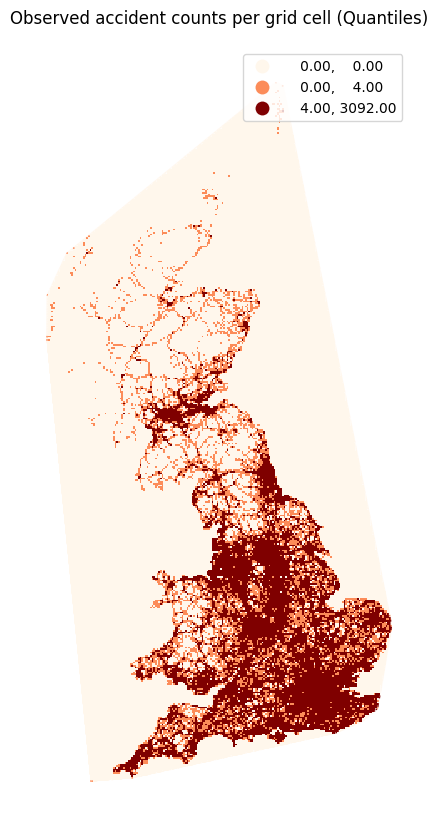

In [25]:
# Observed accident counts per cell
fig, ax = plt.subplots(1,1, figsize=(10,10))
grid.plot(column='acc_count', ax=ax, scheme='Quantiles', k=6, cmap='OrRd', legend=True)
ax.set_title("Observed accident counts per grid cell (Quantiles)")
ax.set_axis_off()
out_png = os.path.join(WORK_DIR, "observed_accident_heatmap.png")
fig.savefig(out_png, bbox_inches='tight', dpi=200)
print("Saved observed heatmap:", out_png)
plt.show()


C:\Users\Croma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\mapclassify\classifiers.py:1767: UserWarning: Not enough unique values in array to form 6 classes. Setting k to 3.
  self.bins = quantile(y, k=k)


Saved predicted heatmap: C:\Users\Croma\stats19_run_outputs\predicted_accident_heatmap.png


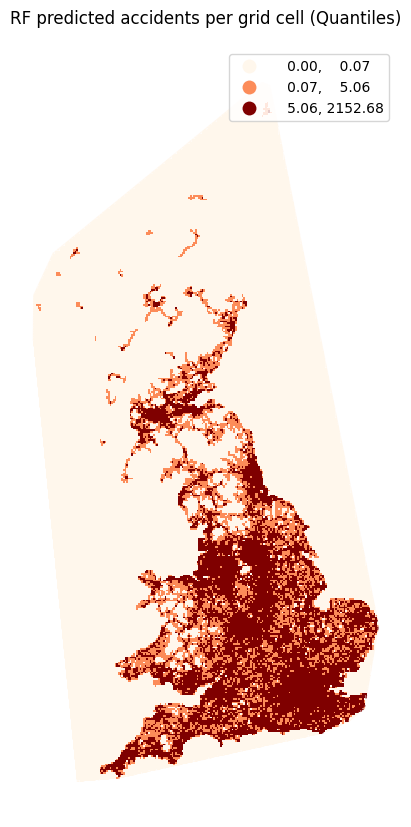

In [26]:
# Predicted accidents per cell
fig, ax = plt.subplots(1,1, figsize=(10,10))
grid.plot(column='pred_acc_rf', ax=ax, scheme='Quantiles', k=6, cmap='OrRd', legend=True)
ax.set_title("RF predicted accidents per grid cell (Quantiles)")
ax.set_axis_off()
out_png = os.path.join(WORK_DIR, "predicted_accident_heatmap.png")
fig.savefig(out_png, bbox_inches='tight', dpi=200)
print("Saved predicted heatmap:", out_png)
plt.show()


C:\Users\Croma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\mapclassify\classifiers.py:1767: UserWarning: Not enough unique values in array to form 6 classes. Setting k to 3.
  self.bins = quantile(y, k=k)
C:\Users\Croma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\mapclassify\classifiers.py:1767: UserWarning: Not enough unique values in array to form 6 classes. Setting k to 3.
  self.bins = quantile(y, k=k)


Saved side-by-side map: C:\Users\Croma\stats19_run_outputs\observed_vs_predicted_side_by_side.png


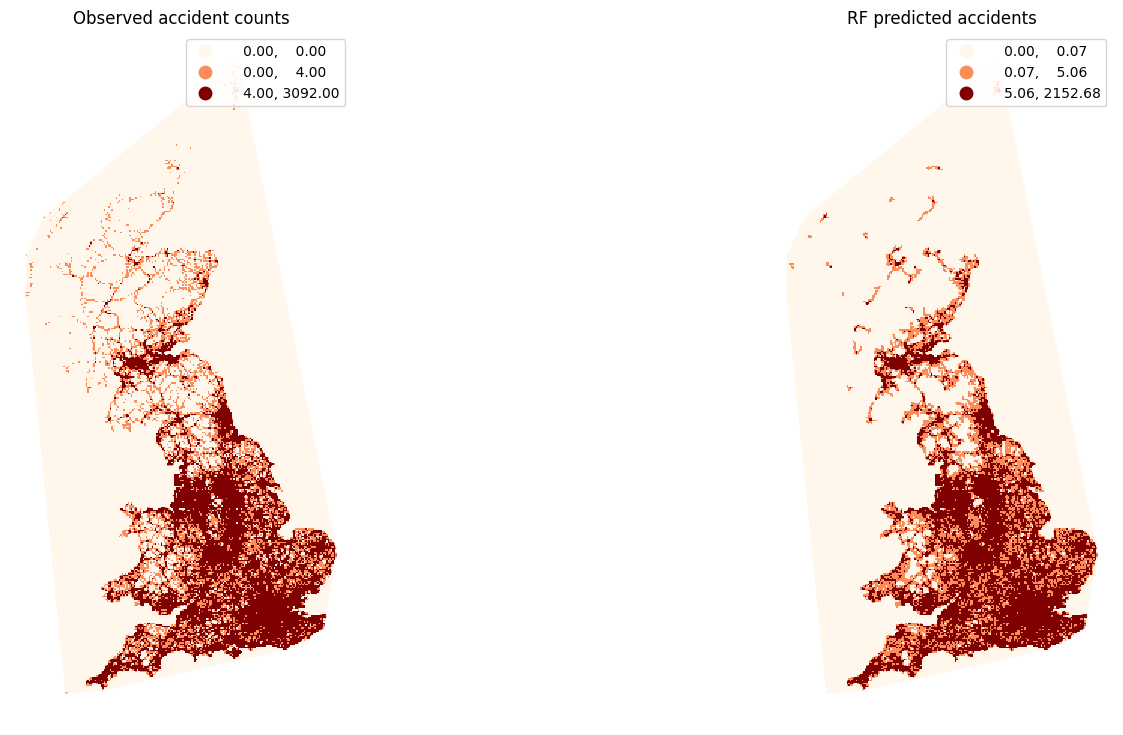

In [27]:
fig, axes = plt.subplots(1,2, figsize=(18,9))
grid.plot(column='acc_count', ax=axes[0], scheme='Quantiles', k=6, cmap='OrRd', legend=True)
axes[0].set_title("Observed accident counts")
axes[0].set_axis_off()

grid.plot(column='pred_acc_rf', ax=axes[1], scheme='Quantiles', k=6, cmap='OrRd', legend=True)
axes[1].set_title("RF predicted accidents")
axes[1].set_axis_off()

out_png = os.path.join(WORK_DIR, "observed_vs_predicted_side_by_side.png")
fig.savefig(out_png, bbox_inches='tight', dpi=200)
print("Saved side-by-side map:", out_png)
plt.show()


Saved top hotspots centroids: C:\Users\Croma\stats19_run_outputs\top_50_hotspot_centroids.png


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1277632312.py:26: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  'centroid_lon': top_wgs.centroid.x,
C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1277632312.py:27: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  'centroid_lat': top_wgs.centroid.y


Saved top hotspots CSV: C:\Users\Croma\stats19_run_outputs\top_50_hotspots.csv


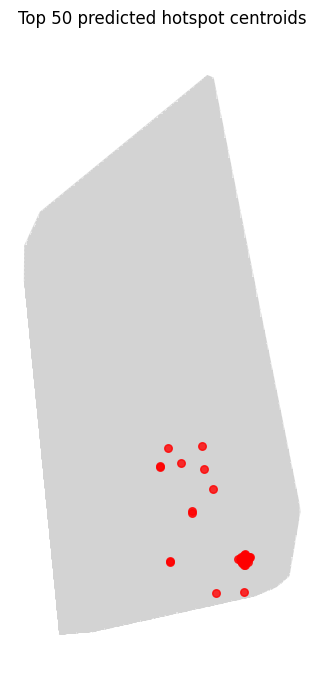

In [28]:
# Top N predicted hotspot cells
topN = 50
top = grid.sort_values('pred_acc_rf', ascending=False).head(topN).copy()
top['centroid'] = top.geometry.centroid
xs = [p.x for p in top.centroid]
ys = [p.y for p in top.centroid]

fig, ax = plt.subplots(figsize=(8,8))
grid.plot(ax=ax, color='lightgrey', linewidth=0.1)
ax.scatter(xs, ys, c='red', s=30, alpha=0.8)
for i, r in top[['grid_id','pred_acc_rf']].iterrows():
    pass  # skip labeling to keep plot clean

ax.set_title(f"Top {topN} predicted hotspot centroids")
ax.set_axis_off()
out_png = os.path.join(WORK_DIR, f"top_{topN}_hotspot_centroids.png")
fig.savefig(out_png, bbox_inches='tight', dpi=200)
print("Saved top hotspots centroids:", out_png)

# also save CSV with details and centroid lon/lat (WGS84)
top_wgs = top.to_crs(epsg=4326)
top_df = pd.DataFrame({
    'grid_id': top_wgs.grid_id,
    'pred_acc_rf': top_wgs.pred_acc_rf,
    'acc_count': top_wgs.acc_count,
    'centroid_lon': top_wgs.centroid.x,
    'centroid_lat': top_wgs.centroid.y
})
csv_out = os.path.join(WORK_DIR, f"top_{topN}_hotspots.csv")
top_df.to_csv(csv_out, index=False)
print("Saved top hotspots CSV:", csv_out)


C:\Users\Croma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|===================| 3095/3103 [02:26<00:00]        C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\539795628.py:13: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(sv, Xs, plot_type="bar", show=True)


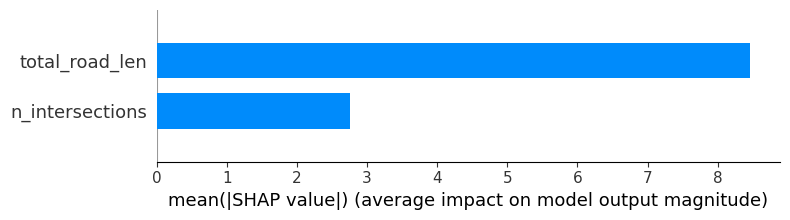

AttributeError: module 'shap.plots._beeswarm' has no attribute 'pyplot_figure'

In [29]:
import shap, numpy as np
# sample rows for SHAP
sample_frac = 0.05  # 5% sample => ~3000 rows (tweak as needed)
X = grid[feat_cols].fillna(0)
n = max(500, int(len(X)*sample_frac))
np.random.seed(42)
idx = np.random.choice(len(X), size=n, replace=False)
Xs = X.iloc[idx]

explainer = shap.Explainer(rf_final, Xs)
sv = explainer(Xs)
# summary plot (bar)
shap.summary_plot(sv, Xs, plot_type="bar", show=True)
# save the figure programmatically (matplotlib wrapper)
fig = shap.plots._beeswarm.pyplot_figure() if hasattr(shap.plots, '_beeswarm') else None
# alternatively just inform user
print("Displayed SHAP summary for sample (no PNG auto-save).")


In [30]:
import folium, json
# convert grid to WGS84 for folium
grid_wgs = grid.to_crs(epsg=4326)
gj = json.loads(grid_wgs[['grid_id','pred_acc_rf','acc_count','geometry']].to_json())

# map center
cent = grid_wgs.geometry.unary_union.centroid
m_center = [cent.y, cent.x]

m = folium.Map(location=m_center, zoom_start=7, tiles='cartodbpositron')

folium.Choropleth(
    geo_data=gj,
    data=grid_wgs,
    columns=['grid_id','pred_acc_rf'],
    key_on='feature.properties.grid_id',
    fill_opacity=0.8,
    line_opacity=0.1,
    legend_name='Predicted accidents (RF)'
).add_to(m)

# add top 20 markers
top20 = grid_wgs.sort_values('pred_acc_rf', ascending=False).head(20)
for _, r in top20.iterrows():
    c = r.geometry.centroid
    folium.CircleMarker(location=[c.y, c.x],
                        radius=6, color='red', fill=True, fill_opacity=0.8,
                        popup=f"grid_id:{r['grid_id']} pred:{r['pred_acc_rf']:.2f} obs:{int(r['acc_count'])}"
                       ).add_to(m)

map_path = os.path.join(WORK_DIR, "pred_map.html")
m.save(map_path)
print("Saved interactive folium map:", map_path)


C:\Users\Croma\AppData\Local\Temp\ipykernel_8540\1384426838.py:7: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  cent = grid_wgs.geometry.unary_union.centroid


Saved interactive folium map: C:\Users\Croma\stats19_run_outputs\pred_map.html
